In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
# Load the dataset
df1 = pd.read_csv("/content/drive/MyDrive/colab /traindata1.csv")  # Replace 'your_dataset.csv' with the path to your dataset
df1.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [12]:
df=df1[['tweet','label']]

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
# Preprocess the text data using SpaCy
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nlp = spacy.load('en_core_web_sm')

def preprocess_text(data):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    data = whitespace.sub(' ', data)
    data = user.sub('', data)
    data = re.sub(r"\[[^()]*\]","", data)
    data = re.sub("\d+", "", data)
    data = re.sub(r'[^\w\s]','',data)
    data = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", data)
    text = data.lower()
    
    # removing stop-words
    data = [word for word in data.split() if word not in list(stopwords.words('english'))]
    
    # word lemmatization
    sentence = []
    for word in data:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence) 

df['processed_tweet'] = df['tweet'].apply(preprocess_text)  # Replace 'text_column' with the actual column name in your dataset


In [15]:
df.head()

,tweet,label,processed_tweet
0,@user when a father is dysfunctional and is s...,0,father dysfunctional selfish drag kid dysfunct...
1,@user @user thanks for #lyft credit i can't us...,0,thank lyft credit cant use cause dont offer wh...
2,bihday your majesty,0,bihday majesty
3,#model i love u take with u all the time in ...,0,model love u take u time urð ðððð ððð
4,factsguide: society now #motivation,0,factsguide society motivation


In [16]:
X = df['processed_tweet'].values
y = df['label'].values  # Replace 'label_column' with the actual column name in your dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [17]:
# Initialize the TfidfVectorizer and MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()

# Create a pipeline combining the vectorizer and classifier
pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])

In [18]:
# Define the hyperparameters to search
parameters = {
    'vectorizer__max_features': [1000, 5000, 10000],  # Experiment with different values
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Experiment with different n-gram ranges
    'classifier__alpha': [0.1, 1.0, 10.0]  # Experiment with different alpha values
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

In [19]:
# Predict on the test set
y_pred = best_model.predict(X_test)

print('Confusion Matrix (Testing Data):')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


Confusion Matrix (Testing Data):
      0    1
0  5914   43
1   213  223
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5957
           1       0.84      0.51      0.64       436

    accuracy                           0.96      6393
   macro avg       0.90      0.75      0.81      6393
weighted avg       0.96      0.96      0.96      6393



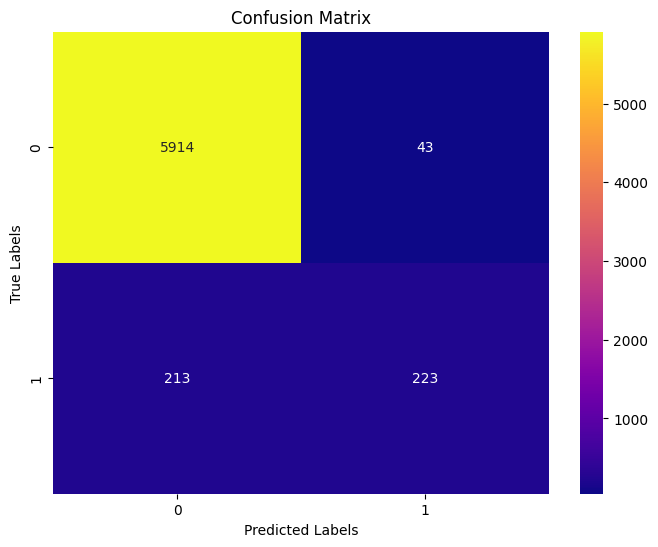

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

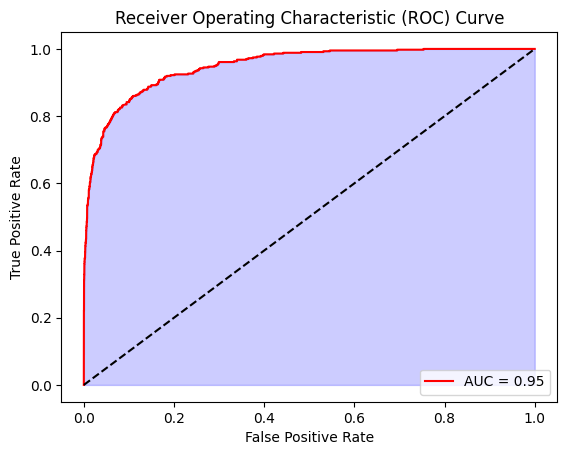

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have the best model and test data (X_test, y_test)

# Get predicted probabilities for the positive class
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Compute the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='red')
plt.fill_between(fpr, tpr, color='blue', alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line representing random classification
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

